## Classifying news-wires a multiclass classification:
This problem is a instance of multiclass classification
because each data point should be classified into one category ,
the problem is more specifically an instance of single label multiclass
classification.

### Reuters dataset


In [1]:
from tensorflow.keras.datasets import reuters
(train_data,train_labels) , (test_data, test_labels) = reuters.load_data(
    num_words=10000
)

print(len(train_data))
print(len(test_data))

2021-08-05 00:57:23.777493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-05 00:57:23.777550: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/mgrdich/.local/share/virtualenvs/deep_learning_python-pzRhtxR0/lib/python3.8/site-packages/tensorflow/python/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/mgrdich/.local/share/virtualenvs/deep_learning_python-pzRhtxR0/lib/python3.8/site-packages/tensorflow/python/keras/datasets/reuters

8982
2246


### Decoding news-wires back to text



In [2]:
word_index = reuters.get_word_index()
reverse_word_index = {v: k for k, v in word_index.items()}
decoded_newswire = ''.join([
    reverse_word_index.get(i-3,'?') for i in train_data[0]
])
print(decoded_newswire)

???saidasaresultofitsdecemberacquisitionofspacecoitexpectsearningspersharein1987of115to130dlrspershareupfrom70ctsin1986thecompanysaidpretaxnetshouldrisetonineto10mlndlrsfromsixmlndlrsin1986andrentaloperationrevenuesto19to22mlndlrsfrom125mlndlrsitsaidcashflowpersharethisyearshouldbe250tothreedlrsreuter3


the label associated with an example is an integer between `0-45` topic index

In [3]:
train_labels[0]
print(reverse_word_index[train_labels[0]])
# probably not decoded this way


to


In [4]:
# vectorized
from util.functions import vectorize_sequences
x_train = vectorize_sequences(train_data,10000)
x_test = vectorize_sequences(test_data,10000)

# OR categorical encoding
from tensorflow.keras.utils import to_categorical
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)


### Building your Network
But there is a new constraint here: the number of output classes has gone from 2 to 46. The
dimensionality of the output space is much larger.

In Stack of `Dense` Layers like you've been using each layer can only access information
present in the output the previous layer

In [5]:
from tensorflow.keras import models , layers
model = models.Sequential()
model.add(layers.Dense(64,activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))

2021-08-05 00:57:26.961023: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-05 00:57:27.030827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-05 00:57:27.031931: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 950M computeCapability: 5.0
coreClock: 1.124GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 29.83GiB/s
2021-08-05 00:57:27.032282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-05 00:57:27.032559: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcu

There are two things two know about this architecture
* You end the network with a dense layer of size 46. Each entry in this vec-
tor (each dimension) will encode a different output class.
* The last layer uses `softmax` activation , the network will output
`probability Distribution` over `46` different output classes
`output[i]` is the probability that the sample belongs to class `i`. The scores
`46` will sum to `1`.

`categorical_crossentropy` . It measures the distance between two probability distributions

In [6]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

### Validating you approach


In [7]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [8]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val,y_val)
)

2021-08-05 00:57:27.486691: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 319280000 exceeds 10% of free system memory.
2021-08-05 00:57:27.729336: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-05 00:57:27.731395: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2599990000 Hz
2021-08-05 00:57:28.549563: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 40000000 exceeds 10% of free system memory.


Epoch 1/20
16/16 [==============================] - 1s 33ms/step - loss: 2.6852 - accuracy: 0.5175 - val_loss: 1.7755 - val_accuracy: 0.6200
Epoch 2/20
16/16 [==============================] - 0s 19ms/step - loss: 1.4508 - accuracy: 0.6963 - val_loss: 1.3375 - val_accuracy: 0.6970

### let's display the loss accuracy


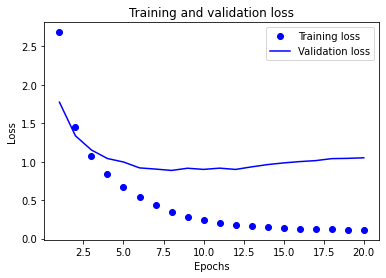

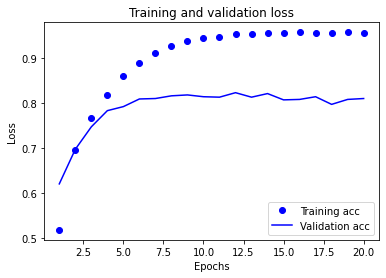

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf() # clears the figure


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### The network begins to overfit after nine epochs.
#### Let's train a new network from scratch for nine epochs and then evaluate it

In [18]:
# Retraining a model from scratch
model = models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

print(results)


2021-08-05 01:15:46.990347: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 319280000 exceeds 10% of free system memory.
2021-08-05 01:15:48.016947: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 40000000 exceeds 10% of free system memory.
2021-08-05 01:15:50.668425: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 89840000 exceeds 10% of free system memory.


Epoch 1/9
16/16 [==============================] - 1s 29ms/step - loss: 2.6607 - accuracy: 0.5247 - val_loss: 1.7363 - val_accuracy: 0.6330
Epoch 2/9
16/16 [==============================] - 0s 20ms/step - loss: 1.4130 - accuracy: 0.7106 - val_loss: 1.3136 - val_accuracy: 0.7290

This approach reaches an accuracy of 80% approximately , with binary classification
problem the accuracy reached by a purely random classifier would be 50%
but in this case is closer to 19%

In [20]:
import copy
import numpy as np
test_labels_copy = copy.copy(test_labels)
print(np.random.shuffle(test_labels_copy))
#TODO ask this part
hits_array = np.array(test_labels) == np.array(test_labels_copy)
print(float(np.sum(hits_array)/len(test_labels)))

None
0.19634906500445237


## Getting prediction on the new data


In [24]:
predictions = model.predict(x_test)
print(predictions[0].shape)

# the coefficients in this vector is 1:
print(np.sum(predictions[0]))

# he largest entry is the predicted class—the class with the highest probability:

print(np.argmax(predictions[0]))

(46,)
0.9999998
3


### Different way of handling labels and loss